In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
import json

/home/timetraveller/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/timetraveller/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
def clean_data(price_data):
    price_data=price_data.drop(['high','low','volumefrom','volumeto','open'],axis=1).copy()
    price_data['date']=pd.to_datetime(price_data['time'],unit='s')
    price_data=price_data.set_index('time')
    price_data.rename(columns={'close':'price'},inplace=True)
    return price_data
    

In [10]:
with open('historic_price_data.json') as data_file:    
    json_data = json.load(data_file)
price_data=pd.DataFrame(json_data['Data'])    
price_data=clean_data(price_data)
price_data.tail()

,price,date
time,,
1536192000,6515.42,2018-09-06
1536278400,6411.78,2018-09-07
1536364800,6200.16,2018-09-08
1536451200,6249.07,2018-09-09
1536537600,6336.92,2018-09-10


In [11]:
def cat_prev_years(cur_data,price_data):
    cur_data['p_2017'],cur_data['p_2016'],cur_data['p_2015'],cur_data['p_2014']=[0,0,0,0]
    cur_data
    for index,row in cur_data.iterrows():
        for year in [1,2,3,4]:
            key='p_201'+str(8-year)
            year_stamp=index-(365*86400*year)
            cur_data.at[index,key]=price_data.loc[year_stamp].price
    return cur_data       
    

In [12]:
# price_data.head()
# 251 days have elapsed to this year as of 2018-09-10 (september)
cur_data=price_data.iloc[(2000-251):2000].copy()
cur_data=cat_prev_years(cur_data,price_data)


In [13]:
import seaborn as sns
def display_pair_plot(cur_data):
    sns.pairplot(cur_data)

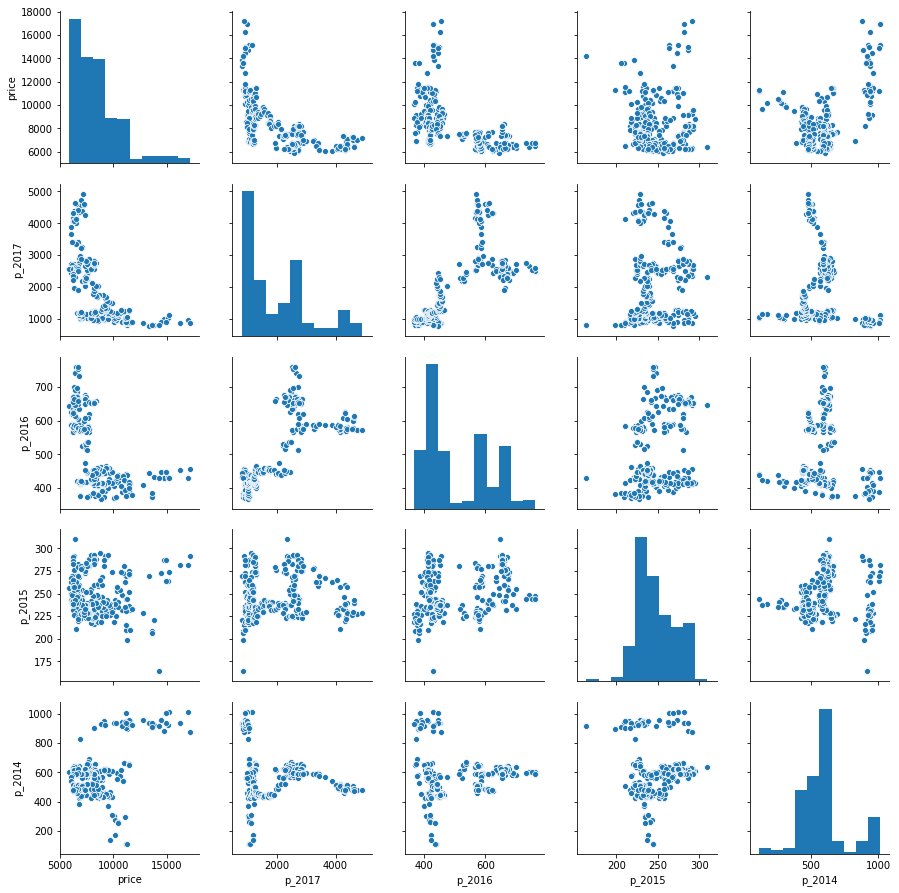

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X=cur_data[['p_2017','p_2016','p_2015','p_2014']]
y=cur_data['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10)
display_pair_plot(cur_data)

In [29]:
def plot_price(data):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(pd.to_datetime(data.index,unit='s'),data,'r.')
 
def plot_prediction(x,predict,model,param):
    plt.rcParams["figure.figsize"] = (15,5)
    if(model=='regression'):
        _title='Linear Regression | Alpha: '+str(param)
    elif(model=='decision_tree'):
        _title='Decision Tree | Depth: '+str(param)
    elif(model=='neural_mlp'):
        _title='MLP neural network | Hidden layers: '+str(param[0])+" | Alpha: "+str(param[1])    
    elif(model=='rfr'):
        _title='Random Forest: '
    else:
        _title='Plot'
    plt.title(_title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(pd.to_datetime(x.index,unit='s'),predict,'r.',label='prediction')
    plt.plot(pd.to_datetime(x.index,unit='s'),x,'b.',label='actual')
    plt.legend(loc='lower left')
    
    

In [16]:
from sklearn.linear_model import Ridge
def linear_regression(X_train,X_test,y_train,y_test,_alpha):
    rr=Ridge(alpha=_alpha).fit(X_train,y_train)
    train_score=rr.score(X_train,y_train)
    test_score=rr.score(X_test,y_test)
    prediction=rr.predict(X_test)
    return train_score,test_score,prediction,rr

Train score:  0.5423407367874298 
Test score:  0.5645936489540864


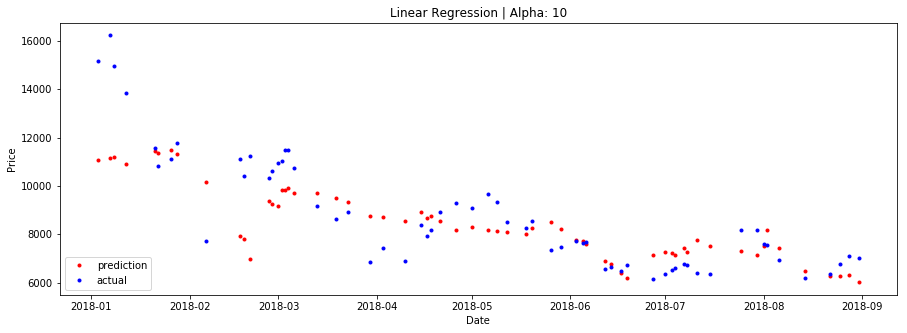

In [17]:
_alpha=10
train_score,test_score,prediction,regression_model_object=linear_regression(X_train,X_test,y_train,y_test,_alpha)
plot_prediction(y_test,prediction,"regression",_alpha)
print("Train score: ",train_score,"\nTest score: ",test_score)

In [18]:
from sklearn.tree import DecisionTreeRegressor
def d_tree(X_train,X_test,y_train,y_test,_max_depth):
    dt=DecisionTreeRegressor(max_depth=_max_depth).fit(X_train,y_train)
    train_score=dt.score(X_train,y_train)
    test_score=dt.score(X_test,y_test)
    prediction=dt.predict(X_test)
    return train_score,test_score,prediction,dt
    

Train score:  0.9554187135388673 
Test score:  0.8719972157290998


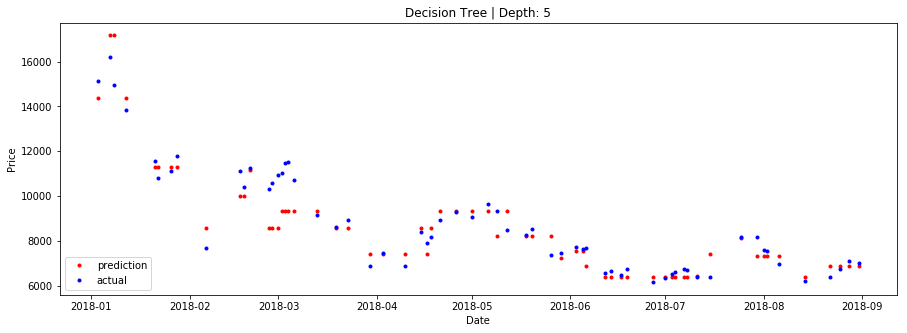

In [19]:
_max_depth=5
train_score,test_score,prediction,dt_model_object=d_tree(X_train,X_test,y_train,y_test,_max_depth)
plot_prediction(y_test,prediction,"decision_tree",_max_depth)
print("Train score: ",train_score,"\nTest score: ",test_score)

In [20]:
from sklearn.preprocessing import MinMaxScaler

def normalize(X_train,X_test,y_train,y_test):
    scaler=MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

In [21]:
from sklearn.neural_network import MLPRegressor
def neural_mlp(X_train,X_test,y_train,y_test,params):
    mlp_nn=MLPRegressor(hidden_layer_sizes=params[0],solver='lbfgs',alpha=params[1]).fit(X_train,y_train)
    train_score=mlp_nn.score(X_train,y_train)
    test_score=mlp_nn.score(X_test,y_test)
    prediction=mlp_nn.predict(X_test)
    return train_score,test_score,prediction,mlp_nn

Train score:  0.6913306650597393 
Test score:  0.7042450476800826


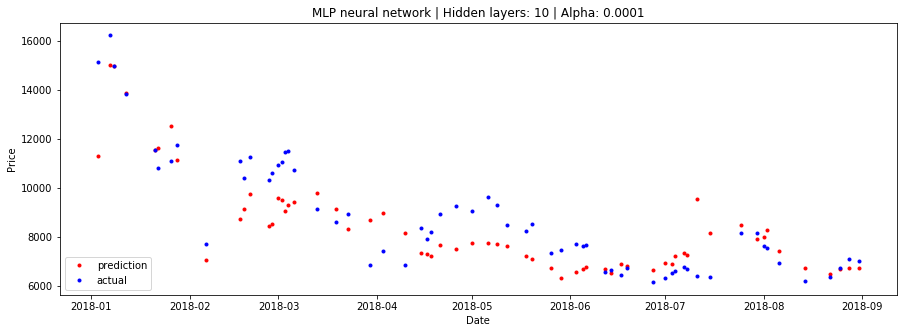

In [22]:
_hidden_layer_sizes=10
_nn_alpha=0.0001
train_score,test_score,prediction,neural_mlp_object=neural_mlp(X_train,X_test,y_train,y_test,[_hidden_layer_sizes,_nn_alpha])
plot_prediction(y_test,prediction,"neural_mlp",[_hidden_layer_sizes,_nn_alpha])
print("Train score: ",train_score,"\nTest score: ",test_score)

In [38]:
from sklearn.ensemble import RandomForestRegressor
def random_forest(X_train,X_test,y_train,y_test):
    rfr=RandomForestRegressor(n_jobs=-1)
    rfr.fit(X_train,y_train)
    train_score=rfr.score(X_train,y_train)
    test_score=rfr.score(X_test,y_test)
    prediction=rfr.predict(X_test)
    return train_score,test_score,prediction,rfr
    

Train score:  0.9777331163394543 
Test score:  0.9036683714756876


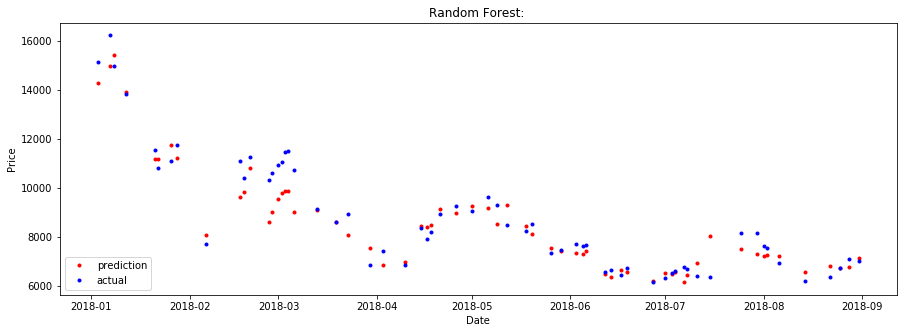

In [40]:
train_score,test_score,prediction,rfr=random_forest(X_train,X_test,y_train,y_test)
plot_prediction(y_test,prediction,"rfr",None)
print("Train score: ",train_score,"\nTest score: ",test_score)

In [24]:
import time
import datetime 

def date_to_timestamp(_date):
    year,month,day=_date[0],_date[1],_date[2]
    timestamp=datetime.datetime(year,month,day).timestamp()
    return int(timestamp)
    

In [25]:
def generate_features(timestamp,price_data):
    features=pd.DataFrame()
    features['p_2017'],features['p_2016'],features['p_2015'],features['p_2014']=[0,0,0,0]
    for year in [1,2,3,4]:
        key='p_201'+str(8-year)
        year_stamp=timestamp-(365*86400*year)
        features.at[0,key]=price_data.loc[year_stamp].price
    return features           
    

In [26]:
def predict_price(features,model):
    prediction=model.predict(features)
    return prediction     

In [27]:
timestamp=date_to_timestamp([2018,9,10])
features=generate_features(timestamp,price_data)
price=float(predict_price(features,neural_mlp_object))
print("Predicted price is: {:.2f}".format(price))

Predicted price is: 6594.51


In [43]:
timestamp=date_to_timestamp([2018,12,16])
features=generate_features(timestamp,price_data)
price=float(predict_price(features,rfr))
print("Predicted price is: {:.2f}".format(price))

Predicted price is: 7851.86
